In [11]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

from args import get_test_args
from collections import OrderedDict
from json import dumps
from models import BiDAF, QANet, UnifiedQANet
from os.path import join
from tensorboardX import SummaryWriter
from tqdm import tqdm
from ujson import load as json_load
from util import collate_fn, SQuAD, metric_max_over_ground_truths, compute_em, compute_f1, compute_avna

In [12]:
train_dataset = SQuAD('./data/train.npz', True)
dev_dataset = SQuAD('./data/dev.npz', True)

In [13]:
word_vectors = util.torch_from_json('./data/word_emb.json')
char_vectors = util.torch_from_json('./data/char_emb.json')

In [14]:
print(word_vectors.shape)
print(char_vectors.shape)

torch.Size([88714, 300])
torch.Size([1376, 64])


In [15]:
ys_train = list(zip(train_dataset.y1s.numpy(), train_dataset.y2s.numpy()))
ys_dev = list(zip(dev_dataset.y1s.numpy(), dev_dataset.y2s.numpy())) 
df_train = pd.DataFrame(ys_train, columns=['y1', 'y2'])
df_dev = pd.DataFrame(ys_dev, columns=['y1', 'y2'])

In [16]:
def calculate_len(row):
    if row[0] == 0 and row[1] == 0:
        return 0
    else:
        return row[1] - row[0] + 1

In [17]:
answer_len = df_dev.apply(calculate_len, axis=1)
v = pd.value_counts(answer_len)[:16]
list(v/v.sum())

[0.5245098039215687,
 0.16700473292765383,
 0.10378634212305612,
 0.07606490872210954,
 0.04006085192697769,
 0.02636916835699797,
 0.016396213657876944,
 0.013015551048005409,
 0.007944557133198107,
 0.006254225828262339,
 0.004394861392832995,
 0.0042258282623394185,
 0.003211629479377958,
 0.002704530087897228,
 0.002535496957403651,
 0.0015212981744421906]

In [18]:
(df_dev.y2-df_dev.y1).describe()

count    5951.000000
mean        1.057469
std         2.484721
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        28.000000
dtype: float64

In [19]:
sum(((df_train.y1==0)&(df_train.y2==0)))/len(df_train)

0.33369760121901476

In [20]:
sum(((df_dev.y1==0)&(df_dev.y2==0)))/len(df_dev)

0.5214249705931776

In [21]:
device, gpu_ids = util.get_available_devices()

In [22]:
model = UnifiedQANet(word_vectors=word_vectors,
              char_vectors=char_vectors,
              hidden_size=128,
              num_head=4)

In [23]:
def load_model(model, checkpoint_path, gpu_ids, return_step=True):
    """Load model parameters from disk.

    Args:
        model (torch.nn.DataParallel): Load parameters into this model.
        checkpoint_path (str): Path to checkpoint to load.
        gpu_ids (list): GPU IDs for DataParallel.
        return_step (bool): Also return the step at which checkpoint was saved.

    Returns:
        model (torch.nn.DataParallel): Model loaded from checkpoint.
        step (int): Step at which checkpoint was saved. Only if `return_step`.
    """
    device = 'cpu'
    ckpt_dict = torch.load(checkpoint_path, map_location=device)

    # Build model, load parameters
    model.load_state_dict(ckpt_dict['model_state'], strict=False)

    if return_step:
        step = ckpt_dict['step']
        return model, step

    return model

In [24]:
model = nn.DataParallel(model, gpu_ids)
model = load_model(model, 'save/train/uqanet-02/best.pth.tar', None, return_step=False)
model = model.to(device)
model.eval()

DataParallel(
  (module): UnifiedQANet(
    (emb): Embedding(
      (word_emb): Embedding(88714, 300)
      (char_emb): Embedding(1376, 64)
      (seg_emb): Embedding(2, 128)
      (conv2d): Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1))
      (conv1d_word): FeedForward(
        (out): Linear(in_features=300, out_features=128, bias=False)
      )
      (conv1d): FeedForward(
        (out): Linear(in_features=256, out_features=128, bias=False)
      )
      (hwy): HighwayEncoder(
        (transforms): ModuleList(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
        (gates): ModuleList(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
      )
    )
    (emb_enc_blks): ModuleList(
      (0): EncoderBlock(
        (convs): ModuleList(
          (0): DepthwiseSeparableConv(
            (depth

In [25]:
dataset = dev_dataset
data_loader = data.DataLoader(dataset,
                              batch_size=64,
                              shuffle=False,
                              num_workers=4,
                              collate_fn=collate_fn)

In [26]:
for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader: 
    print(y1, y2)
    break

tensor([ 35,  22,  56,  66, 128,   0,   0,   0,   0, 177, 104,  41,   0,   0,
          0,   0,   0,  64,  58,   0,   0,  43,  62, 131,   0,   0,   0,   0,
          2,   0,   0,  21,  57,   0,   0,   0,  75,   0,   0,   0,  29,   0,
          0,   0,   0,  15,  55,  99,   0,   0,   0,   0, 104,  48,   4,   0,
          0,   0,   0,  32,   0,   0,   0,   1]) tensor([ 35,  25,  60,  66, 128,   0,   0,   0,   0, 179, 105,  41,   0,   0,
          0,   0,   0,  66,  59,   0,   0,  43,  64, 131,   0,   0,   0,   0,
          2,   0,   0,  21,  57,   0,   0,   0,  76,   0,   0,   0,  31,   0,
          0,   0,   0,  17,  57, 100,   0,   0,   0,   0, 104,  48,   5,   0,
          0,   0,   0,  39,   0,   0,   0,   2])


In [27]:
(y1 == 0) & (y2==0)

tensor([False, False, False, False, False,  True,  True,  True,  True, False,
        False, False,  True,  True,  True,  True,  True, False, False,  True,
         True, False, False, False,  True,  True,  True,  True, False,  True,
         True, False, False,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True,  True, False, False, False,  True,  True,
         True,  True, False, False, False,  True,  True,  True,  True, False,
         True,  True,  True, False])

In [28]:
nll_meter = util.AverageMeter()
pred_dict = {}  # Predictions for TensorBoard
prob_dict = {}
eval_file = './data/dev_eval.json'
with open(eval_file, 'r') as fh:
    gold_dict = json_load(fh)
with torch.no_grad(), \
        tqdm(total=len(dataset)) as progress_bar:
    for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
        # Setup for forward
        cw_idxs = cw_idxs.to(device)
        qw_idxs = qw_idxs.to(device)
        cc_idxs = cc_idxs.to(device)
        qc_idxs = qc_idxs.to(device)
        #print(cw_idxs.shape)
        #print(qw_idxs.shape)
        #print(cc_idxs.shape)
        #print(qc_idxs.shape)
        batch_size = cw_idxs.size(0)

        # Forward
        log_p1, log_p2 = model(cw_idxs, qw_idxs, cc_idxs, qc_idxs)
        y1, y2 = y1.to(device), y2.to(device)
        loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
        nll_meter.update(loss.item(), batch_size)

        # Get F1 and EM scores
        p1, p2 = log_p1.exp(), log_p2.exp()
        starts, ends = util.discretize(p1, p2, 64, True)

        # Log info
        progress_bar.update(batch_size)

        idx2pred, uuid2pred = util.convert_tokens(gold_dict,
                                                  ids.tolist(),
                                                  starts.tolist(),
                                                  ends.tolist(),
                                                  True)
        score_null = [x[0].item() * y[0].item() for x, y in zip(p1, p2)]
        #score_has = [max([x[i].item() + y[j].item() for i, j in combinations(range(1, len(x)), 2)]) for x, y in zip(p1, p2)]
        score_has = []
        p1 = p1.cpu().numpy()
        p2 = p2.cpu().numpy()
        for x, y in zip(p1, p2):
            max_score = float('-inf')
            for i in range(1, len(x)-1):
                for j in range(i+1, min(i+16, len(x))):
                    tmp = x[i].item() * y[j].item()
                    max_score = tmp if tmp > max_score else max_score
            score_has.append(max_score)
        pred_dict.update(idx2pred)
        prob_dict.update(dict(zip([str(x.item()) for x in ids], [x - y for x, y in zip(score_null, score_has)])))

100%|█████████████████████████████████████████████████████████████████████████████| 5951/5951 [00:38<00:00, 156.00it/s]


In [29]:
util.eval_dicts(gold_dict, pred_dict, True)

{'EM': 66.17375231053605, 'F1': 69.65407397706713, 'AvNA': 76.02083683414553}

In [78]:
def eval_dicts(gold_dict, pred_dict, no_answer, prob_dict=None, threshold=0.5):
    avna = f1 = em = total = 0
    tp = tn = fp = fn = 0
    tp2 = tn2 = fp2 = fn2 = 0
    for key, value in pred_dict.items():
        total += 1
        ground_truths = gold_dict[key]['answers']
        prediction = value
        if ground_truths == [] and prediction == '':
            tp += 1
        elif ground_truths != [] and prediction == '':
            fp += 1
        elif ground_truths == [] and prediction != '':
            fn += 1
        elif ground_truths != [] and prediction != '':
            tn += 1
        if prob_dict[key] > threshold or len(prediction.split()) > 10:
            prediction = ''
        if ground_truths == [] and prediction == '':
            tp2 += 1
        elif ground_truths != [] and prediction == '':
            fp2 += 1
        elif ground_truths == [] and prediction != '':
            fn2 += 1
        elif ground_truths != [] and prediction != '':
            tn2 += 1
        em += metric_max_over_ground_truths(compute_em, prediction, ground_truths)
        f1 += metric_max_over_ground_truths(compute_f1, prediction, ground_truths)
        if no_answer:
            avna += compute_avna(prediction, ground_truths)

    eval_dict = {'EM': 100. * em / total,
                 'F1': 100. * f1 / total}

    if no_answer:
        eval_dict['AvNA'] = 100. * avna / total
    print(tp, fp, tn, fn)
    print(tp2, fp2, tn2, fn2)
    return eval_dict

In [38]:
em_list = []
f1_list = []
avna_list = []

grid = np.linspace(0,0.5, 51)[1:]

for thres in tqdm(grid):
    res = eval_dicts(gold_dict, pred_dict, True, prob_dict, threshold=thres)
    em_list.append(res['EM'])
    f1_list.append(res['F1'])
    avna_list.append(res['AvNA'])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.49it/s]


In [92]:
eval_dicts(gold_dict, pred_dict, True, prob_dict, threshold=0.1)

2162 486 2362 941
2257 611 2237 846


{'EM': 67.13157452528986, 'F1': 69.96604112350448, 'AvNA': 75.51671987901193}

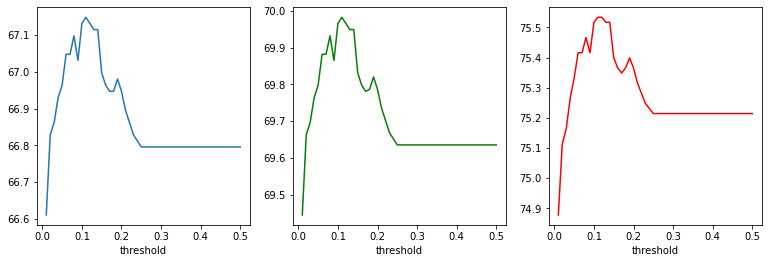

In [63]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
plt.plot(grid, em_list[:])
plt.xlabel('threshold')
plt.subplot(1,3,2)
plt.plot(grid, f1_list[:], 'g')
plt.xlabel('threshold')
plt.subplot(1,3,3)
plt.plot(grid, avna_list[:], 'r')
plt.xlabel('threshold')
plt.show()

In [87]:
(2162+2362)/(941+486+2162+2362)

0.7602083683414552

In [88]:
(2257+2237)/( 846+ 611 +  2257+2237)

0.7551671987901193

In [82]:
2162/(2162+486)

0.8164652567975831

In [83]:
2362/(941+2362)

0.7151074780502573

In [84]:
2257/(611+2257)

0.7869595536959554

In [85]:
2237/(846+2237)

0.7255919558871229

In [94]:
110-35

75